# Walmart Supply Chain Analytics
## Comprehensive Data Analysis Pipeline

---

## Project overview and motivation

Walmart operates one of the most complex retail supply chains on the planet. With thousands of stores, millions of products, and demand patterns that shift based on weather, promotions, holidays, and regional preferences, the operations team faces a fundamental challenge: **how do you ensure the right inventory at the right place at the right time?**

The cost of getting this wrong is substantial. A stockout means lost sales and frustrated customers who may switch to competitors. Excess inventory ties up capital and risks obsolescence. Traditional approaches using static reorder points based on historical averages fail when demand is volatile or when external shocks occur.

### Analysis objectives

This notebook addresses several fundamental questions:

1. **Data quality**: Can we clean and validate the transaction data to ensure reliable analysis?
2. **Pattern discovery**: What patterns exist in demand variability across regions, weather conditions, and time?
3. **Anomaly detection**: Can we identify unusual demand events before they become crises?
4. **Financial impact**: How much revenue is at risk due to stockouts and forecast errors?
5. **Predictive modeling**: Can we forecast demand accurately enough to guide inventory decisions?
6. **Actionable recommendations**: Can we translate analytics into operational decisions?

### Dataset description

The dataset contains **5,000 transactions** across **5 store locations** (Miami, Chicago, Los Angeles, New York, Dallas), spanning categories like Electronics and Appliances. Each record includes:

| Category | Variables |
|----------|----------|
| Inventory metrics | inventory levels, reorder points, supplier lead times |
| Customer data | demographics, loyalty level, payment method |
| Contextual factors | weather conditions, holidays, promotions |
| Demand data | both forecasted and actual demand values |

---

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio
    pio.templates.default = "plotly_white"
    PLOTLY_AVAILABLE = True
except ImportError:
    import subprocess; subprocess.check_call(['pip', 'install', 'plotly', '-q'])
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True

try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB_ENV = True
    file_path = '/content/drive/MyDrive/DM project/Walmart.csv'
except:
    COLAB_ENV = False
    file_path = 'Walmart.csv'

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)

COLORS = {
    'primary': '#0071CE',
    'secondary': '#FFC220',
    'critical': '#DC3545',
    'warning': '#F59E0B',
    'success': '#10B981',
    'info': '#3B82F6',
    'dark': '#1E293B',
    'coastal': '#6366F1',
    'inland': '#F97316',
}

PLOTLY_COLORS = ['#3B82F6', '#10B981', '#F59E0B', '#EF4444', '#8B5CF6',
                 '#06B6D4', '#EC4899', '#6366F1', '#14B8A6', '#F97316']

Mounted at /content/drive


---

## Phase 1: Data Preprocessing

### Motivation

The preprocessing phase serves as the foundation for all subsequent analysis. Models and insights built on dirty data produce unreliable results regardless of algorithmic sophistication. This phase has three critical goals:

1. **Data Quality Assurance**: Identifying and handling duplicates, missing values, and domain constraint violations ensures each transaction is valid and counted exactly once.

2. **Temporal Structuring**: Converting dates and extracting time-based features (hour, day of week, month) captures seasonality and cyclical patterns that drive demand.

3. **Memory Optimization**: Converting strings to categorical types reduces memory footprint by 75%+, enabling faster processing on larger datasets.

### Key Operations

| Operation | Purpose | Method |
|-----------|---------|--------|
| Duplicate removal | Ensure unique transactions | `drop_duplicates()` |
| Missing value analysis | Identify data gaps | `isnull().sum()` |
| Domain validation | Remove impossible values | Filter negative inventory, zero prices |
| Outlier capping | Prevent extreme value skew | IQR method with 3x multiplier |
| Type conversion | Optimize memory | Convert to categorical dtypes |

---

1. data preprocessing

In [6]:
df_raw = pd.read_csv(file_path)
ORIGINAL_ROWS = df_raw.shape[0]
print(f"raw data loaded: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\ncolumns: {list(df_raw.columns)}")
print(f"\ndata types:\n{df_raw.dtypes.value_counts()}")

raw data loaded: 5,000 rows × 28 columns

columns: ['transaction_id', 'customer_id', 'product_id', 'product_name', 'category', 'quantity_sold', 'unit_price', 'transaction_date', 'store_id', 'store_location', 'inventory_level', 'reorder_point', 'reorder_quantity', 'supplier_id', 'supplier_lead_time', 'customer_age', 'customer_gender', 'customer_income', 'customer_loyalty_level', 'payment_method', 'promotion_applied', 'promotion_type', 'weather_conditions', 'holiday_indicator', 'weekday', 'stockout_indicator', 'forecasted_demand', 'actual_demand']

data types:
int64      13
object     10
bool        3
float64     2
Name: count, dtype: int64


In [7]:
# duplicates
dupes = df_raw.duplicated().sum()
print(f"\n1. Duplicates: {dupes:,} rows")

# missing values
missing = df_raw.isnull().sum()
missing_cols = missing[missing > 0]
print(f"\n2. Missing values:")
if len(missing_cols) > 0:
    for col, cnt in missing_cols.items():
        print(f"{col}: {cnt:,} ({cnt/len(df_raw)*100:.1f}%)")
else:
    print("   None detected")

# numeric ranges
print(f"\n3. Numeric column ranges:")
for col in df_raw.select_dtypes(include=[np.number]).columns[:8]:
    print(f"{col}: [{df_raw[col].min():.1f}, {df_raw[col].max():.1f}]  mean={df_raw[col].mean():.1f}")


1. Duplicates: 0 rows

2. Missing values:
promotion_type: 3,407 (68.1%)

3. Numeric column ranges:
transaction_id: [1.0, 5000.0]  mean=2500.5
customer_id: [1001.0, 9998.0]  mean=5542.5
product_id: [100.0, 999.0]  mean=551.2
quantity_sold: [1.0, 5.0]  mean=3.0
unit_price: [50.1, 1999.8]  mean=1023.5
store_id: [1.0, 20.0]  mean=10.5
inventory_level: [0.0, 500.0]  mean=253.1
reorder_point: [50.0, 150.0]  mean=99.8


In [8]:
df = df_raw.copy()

# remove duplicates
df = df.drop_duplicates()
print(f"After deduplication: {df.shape[0]:,} rows")

# date conversion + temporal features
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='mixed')
df['transaction_month'] = df['transaction_date'].dt.to_period('M')
df['transaction_week'] = df['transaction_date'].dt.isocalendar().week.astype(int)
df['transaction_hour'] = df['transaction_date'].dt.hour
df['transaction_dayofweek'] = df['transaction_date'].dt.dayofweek  # 0=Mon, 6=Sun

# remove impossible values
valid_mask = ~(
    (df['inventory_level'] < 0) |
    (df['unit_price'] <= 0) |
    (df['actual_demand'] < 0) |
    (df['forecasted_demand'] < 0) |
    (df['supplier_lead_time'] < 0) |
    (df['quantity_sold'] <= 0)
)
df = df[valid_mask].copy()
print(f"After domain validation: {df.shape[0]:,} rows")

# sort by date
df = df.sort_values('transaction_date').reset_index(drop=True)

# weather imputation (forward fill)
df['weather_conditions'] = df['weather_conditions'].ffill().bfill()

# lead time imputation (regional median)
lead_missing = df['supplier_lead_time'].isnull().sum()
if lead_missing > 0:
    df['supplier_lead_time'] = df.groupby('store_location')['supplier_lead_time'].transform(
        lambda x: x.fillna(x.median())
    )
    df['supplier_lead_time'] = df['supplier_lead_time'].fillna(df['supplier_lead_time'].median())
    print(f"Lead time: imputed {lead_missing:,} missing values")

# outlier capping (IQR × 3)
def cap_outliers_iqr(series, multiplier=3.0):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = max(0, Q1 - multiplier * IQR), Q3 + multiplier * IQR
    n_capped = ((series < lower) | (series > upper)).sum()
    return series.clip(lower=lower, upper=upper), n_capped

for col in ['unit_price', 'actual_demand', 'forecasted_demand', 'customer_income']:
    df[col], n = cap_outliers_iqr(df[col])
    if n > 0:
        print(f"   • {col}: {n:,} outliers capped")

# memory optimization
cat_cols = ['store_location', 'category', 'product_name', 'weather_conditions',
            'customer_gender', 'customer_loyalty_level', 'payment_method',
            'promotion_type', 'weekday']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in ['promotion_applied', 'holiday_indicator', 'stockout_indicator']:
    if col in df.columns:
        df[col] = df[col].astype(bool)

mem_before = df_raw.memory_usage(deep=True).sum() / 1024**2
mem_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory: {mem_before:.2f} MB → {mem_after:.2f} MB ({(1-mem_after/mem_before)*100:.0f}% reduction)")

FINAL_ROWS = df.shape[0]
print(f"\npreprocessing complete: {ORIGINAL_ROWS:,} → {FINAL_ROWS:,} rows ({ORIGINAL_ROWS - FINAL_ROWS} removed)")

After deduplication: 5,000 rows
After domain validation: 5,000 rows

Memory: 3.25 MB → 0.79 MB (76% reduction)

preprocessing complete: 5,000 → 5,000 rows (0 removed)


### Preprocessing results analysis

**Key Findings:**

| Metric | Result | Interpretation |
|--------|--------|----------------|
| Duplicates | 0 | Dataset is clean |
| Missing values | `promotion_type`: 68.1% | Expected - only populated when promotion applied |
| Domain violations | 0 rows removed | All values within valid ranges |
| Memory reduction | 76% (3.25 MB -> 0.79 MB) | Significant efficiency gain |
| Final row count | 5,000 (100% retained) | High data quality |

**Interpretation**: The dataset is remarkably clean. The 68.1% missing values in `promotion_type` is not a data quality issue but a structural feature - this field is conditionally populated only when `promotion_applied` is True. No imputation is needed since the missingness is informative rather than problematic.

---

## Phase 2: feature engineering

### Motivation

Raw transaction data describes *what happened*. Feature engineering transforms this into variables that describe *why it matters*. The goal is to create features that capture the underlying dynamics of inventory management:

1. **Forecast Accuracy**: Quantify how well predictions match reality through demand gap metrics
2. **Stockout Risk**: Calculate inventory buffer adequacy relative to demand and lead times
3. **Demand Volatility**: Measure predictability using coefficient of variation
4. **Temporal Patterns**: Capture recent trends through rolling statistics and lag features

### Feature Categories

| Category | Features Created | Purpose |
|----------|------------------|--------|
| Regional | `operational_region`, `weather_zone`, `is_high_complexity` | Enable region-specific analysis |
| Demand Gap | `demand_gap`, `demand_ratio`, `demand_deviation_class` | Quantify forecast accuracy |
| Risk Indicators | `stockout_risk`, `critical_stockout`, `days_of_inventory` | Flag inventory warnings |
| Volatility | `coefficient_of_variation`, `volatility_class` | Measure demand predictability |
| Temporal | Rolling means (7/14 day), lag features (1/7 day) | Capture recent trends |

---

2. feature engineering

### 2.1 regional & weather zone segmentation



In [9]:
# operational region classification
coastal_cities = ['Miami, FL', 'Los Angeles, CA', 'New York, NY']
df['operational_region'] = df['store_location'].apply(
    lambda x: 'Coastal' if x in coastal_cities else 'Inland'
)
df['is_high_complexity'] = (df['operational_region'] == 'Coastal').astype(int)

# weather risk zone
def classify_weather_zone(loc):
    if loc == 'Miami, FL': return 'Hurricane Risk'
    elif loc in ['Chicago, IL', 'New York, NY']: return 'Winter Storm'
    else: return 'Moderate'

df['weather_zone'] = df['store_location'].apply(classify_weather_zone)

print("Regional distribution:")
print(df['operational_region'].value_counts().to_string())
print(f"\nWeather zones:")
print(df['weather_zone'].value_counts().to_string())

Regional distribution:
operational_region
Coastal    2989
Inland     2011

Weather zones:
weather_zone
Moderate          2036
Winter Storm      2000
Hurricane Risk     964


### 2.2 Demand gap analysis

In [10]:
df['demand_gap'] = df['actual_demand'] - df['forecasted_demand']
df['demand_gap_pct'] = (df['demand_gap'] / df['forecasted_demand'].replace(0, np.nan)) * 100
df['demand_ratio'] = df['actual_demand'] / df['forecasted_demand'].replace(0, np.nan)

def classify_deviation(ratio):
    if pd.isna(ratio): return 'Unknown'
    if ratio > 2.0: return 'Severe Underforecast (>2x)'
    if ratio > 1.5: return 'Significant Underforecast'
    if ratio > 1.2: return 'Mild Underforecast'
    if ratio >= 0.8: return 'Within Tolerance'
    if ratio >= 0.5: return 'Overforecast'
    return 'Severe Overforecast (<0.5x)'

df['demand_deviation_class'] = df['demand_ratio'].apply(classify_deviation)

print("Demand deviation distribution:")
print(df['demand_deviation_class'].value_counts().to_string())

Demand deviation distribution:
demand_deviation_class
Within Tolerance               1281
Overforecast                   1007
Severe Overforecast (<0.5x)     764
Severe Underforecast (>2x)      737
Mild Underforecast              634
Significant Underforecast       577


### Demand gap analysis - results interpretation

The demand deviation distribution reveals a **critical insight**: only **25.6%** of transactions have forecasted demand within +/-20% of actual demand ("Within Tolerance"). This indicates systematic forecasting issues:

| Deviation Class | Count | % | Business Impact |
|-----------------|-------|---|----------------|
| Within Tolerance (0.8-1.2x) | 1,281 | 25.6% | Forecast working |
| Overforecast (0.5-0.8x) | 1,007 | 20.1% | Excess inventory risk |
| Severe Overforecast (<0.5x) | 764 | 15.3% | Significant overstock |
| Mild Underforecast (1.2-1.5x) | 634 | 12.7% | Moderate stockout risk |
| Significant Underforecast (1.5-2x) | 577 | 11.5% | High stockout risk |
| Severe Underforecast (>2x) | 737 | 14.7% | Critical stockout risk |

**Strategic Implication**: Before investing in sophisticated inventory optimization, the upstream **forecasting model itself needs attention**. Nearly 75% of forecasts miss the mark significantly, with roughly equal split between over- and under-forecasting.

---

### 2.3 Stockout risk indicators

In [11]:
df['stockout_risk'] = df['inventory_level'] < df['reorder_point']
df['days_of_inventory'] = (df['inventory_level'] / df['actual_demand'].replace(0, np.nan)).clip(upper=365)
df['critical_stockout'] = df['inventory_level'] < (df['reorder_point'] * 0.5)
df['lead_time_buffer'] = df['days_of_inventory'] - df['supplier_lead_time']
df['can_survive_lead_time'] = df['lead_time_buffer'] > 0

print(f"Stockout risk: {df['stockout_risk'].sum():,} ({df['stockout_risk'].mean()*100:.1f}%)")
print(f"Critical stockout: {df['critical_stockout'].sum():,} ({df['critical_stockout'].mean()*100:.1f}%)")

Stockout risk: 938 (18.8%)
Critical stockout: 466 (9.3%)


### Stockout risk analysis - results interpretation

The stockout risk indicators reveal the current vulnerability of inventory positions:

| Risk Level | Count | % | Definition |
|------------|-------|---|------------|
| **At Risk** | 938 | 18.8% | Inventory below reorder point |
| **Critical** | 466 | 9.3% | Inventory below 50% of reorder point |

**Interpretation**: Nearly **1 in 5 transactions** occurs when inventory is already below the reorder point, and almost **1 in 10** is in critical territory. This suggests either:
- Reorder points are set too low
- Supplier lead times are longer than accounted for
- Demand spikes are occurring faster than replenishment

The `days_of_inventory` and `lead_time_buffer` features will help identify which SKUs cannot survive their replenishment cycle.

---

### 2.4 Demand volatility

In [12]:
df['store_category'] = df['store_location'].astype(str) + ' | ' + df['category'].astype(str)

vol = df.groupby('store_category')['actual_demand'].agg(['mean','std']).reset_index()
vol.columns = ['store_category', 'mean_demand', 'std_demand']
vol['coefficient_of_variation'] = vol['std_demand'] / vol['mean_demand']

df = df.merge(vol[['store_category','coefficient_of_variation']], on='store_category', how='left')
df['volatility_class'] = pd.cut(
    df['coefficient_of_variation'],
    bins=[0, 0.3, 0.5, 0.7, np.inf],
    labels=['Low', 'Moderate', 'High', 'Extreme']
)

print("Volatility distribution:")
print(df['volatility_class'].value_counts().to_string())

Volatility distribution:
volatility_class
Moderate    5000
Low            0
High           0
Extreme        0


### 2.5 Promotional & temporal features

In [13]:
df['promo_demand_lift'] = np.where(
    df['promotion_applied'], df['demand_ratio'], np.nan
)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])
df['is_peak_hour'] = df['transaction_hour'].between(10, 20)
df['is_high_income'] = df['customer_income'] > df['customer_income'].quantile(0.75)
df['is_premium_product'] = df['unit_price'] > df['unit_price'].quantile(0.75)

# time-series features (rolling stats by store+category)
df = df.sort_values(['store_category', 'transaction_date'])
for window in [7, 14]:
    df[f'demand_rolling_mean_{window}'] = df.groupby('store_category')['actual_demand'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    df[f'demand_rolling_std_{window}'] = df.groupby('store_category')['actual_demand'].transform(
        lambda x: x.rolling(window, min_periods=1).std().fillna(0)
    )

# lag features
df['demand_lag_1'] = df.groupby('store_category')['actual_demand'].shift(1).fillna(df['actual_demand'].median())
df['demand_lag_7'] = df.groupby('store_category')['actual_demand'].shift(7).fillna(df['actual_demand'].median())

# price-demand interaction
df['price_demand_ratio'] = df['unit_price'] / df['actual_demand'].replace(0, np.nan)

new_features = [
    'operational_region', 'weather_zone', 'is_high_complexity',
    'demand_gap', 'demand_gap_pct', 'demand_ratio', 'demand_deviation_class',
    'stockout_risk', 'days_of_inventory', 'critical_stockout',
    'lead_time_buffer', 'can_survive_lead_time',
    'coefficient_of_variation', 'volatility_class',
    'is_weekend', 'is_peak_hour', 'is_high_income', 'is_premium_product',
    'demand_rolling_mean_7', 'demand_rolling_std_7',
    'demand_rolling_mean_14', 'demand_rolling_std_14',
    'demand_lag_1', 'demand_lag_7', 'price_demand_ratio'
]

print(f"\n{len(new_features)} features engineered")
print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")


25 features engineered
Final shape: 5,000 rows × 59 columns


## Phase 3: anomaly detection

### Motivation

Anomaly detection serves two critical purposes in supply chain analytics:

1. **Early Warning System**: Identify transactions that deviate significantly from expected patterns before they cascade into larger problems
2. **Prioritization**: Create flags for the action deck to help operations teams focus attention where it matters most

### Ensemble Approach

Single-method anomaly detection is inherently brittle - each method has blind spots. We use an **ensemble of three complementary methods**:

| Method | Approach | Strength | Weakness |
|--------|----------|----------|----------|
| **Z-Score** | Statistical deviation (+/-1.8 sigma) | Interpretable, fast | Assumes normality |
| **IQR** | Interquartile range (1.5x multiplier) | Robust to outliers | Insensitive to multivariate patterns |
| **Isolation Forest** | Tree-based isolation | Captures complex patterns | Black box, requires tuning |

By requiring **consensus across at least 2 methods**, we dramatically reduce false positives while maintaining sensitivity to true anomalies. This is the same principle behind medical diagnosis requiring multiple tests.

---

### 3.1 Multi-method anomaly detection

In [14]:
df['demand_zscore'] = df.groupby(['store_location', 'product_name'])['actual_demand'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

SHOCK_THRESHOLD = 1.8
CRASH_THRESHOLD = -1.8

df['is_demand_shock'] = df['demand_zscore'] > SHOCK_THRESHOLD
df['is_demand_crash'] = df['demand_zscore'] < CRASH_THRESHOLD
df['is_demand_anomaly_zscore'] = df['is_demand_shock'] | df['is_demand_crash']

print("Method 1 ->Z-Score (store × product level, ±1.8σ):")
print(f"   Demand shocks (>+1.8σ):  {df['is_demand_shock'].sum():,}")
print(f"   Demand crashes (<-1.8σ): {df['is_demand_crash'].sum():,}")
print(f"   Total anomalies:         {df['is_demand_anomaly_zscore'].sum():,}")

Method 1 ->Z-Score (store × product level, ±1.8σ):
   Demand shocks (>+1.8σ):  25
   Demand crashes (<-1.8σ): 15
   Total anomalies:         40


In [15]:
def iqr_anomaly(group):
    Q1, Q3 = group.quantile(0.25), group.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return (group < lower) | (group > upper)

df['is_demand_anomaly_iqr'] = df.groupby('store_category')['actual_demand'].transform(iqr_anomaly)

print(f"\nMethod 2 —>IQR (store × category level):")
print(f"   Total anomalies: {df['is_demand_anomaly_iqr'].sum():,}")


Method 2 —>IQR (store × category level):
   Total anomalies: 0


In [16]:
iso_features = ['actual_demand', 'demand_gap', 'inventory_level', 'unit_price']
X_iso = df[iso_features].fillna(0)
scaler = StandardScaler()
X_iso_scaled = scaler.fit_transform(X_iso)

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
df['isolation_score'] = iso_forest.fit_predict(X_iso_scaled)
df['is_anomaly_isolation'] = df['isolation_score'] == -1

print(f"\nMethod3 —>Isolation Forest (multivariate, 5% contamination):")
print(f"   Total anomalies: {df['is_anomaly_isolation'].sum():,}")


Method3 —>Isolation Forest (multivariate, 5% contamination):
   Total anomalies: 250


In [17]:
df['anomaly_votes'] = (
    df['is_demand_anomaly_zscore'].astype(int) +
    df['is_demand_anomaly_iqr'].astype(int) +
    df['is_anomaly_isolation'].astype(int)
)

df['is_demand_anomaly'] = df['anomaly_votes'] >= 2

df['is_weather_shock'] = (
    (df['demand_ratio'] > 1.5) &
    (df['weather_conditions'].isin(['Stormy', 'Rainy']))
)
df['is_weather_crash'] = (
    (df['demand_ratio'] < 0.7) &
    (df['weather_conditions'].isin(['Stormy', 'Rainy']))
)
df['has_weather_impact'] = df['is_weather_shock'] | df['is_weather_crash']

print("Anomaly detection summary:\n")

print(f"  Z-Score anomalies:       {df['is_demand_anomaly_zscore'].sum():>6,}")
print(f"  IQR anomalies:           {df['is_demand_anomaly_iqr'].sum():>6,}")
print(f"  Isolation Forest:        {df['is_anomaly_isolation'].sum():>6,}")
print(f"  Consensus (≥2 methods):  {df['is_demand_anomaly'].sum():>6,}")
print(f"  Weather shocks:          {df['is_weather_shock'].sum():>6,}")
print(f"  Weather crashes:         {df['is_weather_crash'].sum():>6,}")

Anomaly detection summary:

  Z-Score anomalies:           40
  IQR anomalies:                0
  Isolation Forest:           250
  Consensus (≥2 methods):      11
  Weather shocks:             652
  Weather crashes:            679


### Anomaly detection - results interpretation

**Method Comparison:**

| Method | Anomalies | Rate | Interpretation |
|--------|-----------|------|----------------|
| Z-Score | 40 | 0.8% | Univariate statistical outliers |
| IQR | 0 | 0% | No extreme outliers beyond whiskers |
| Isolation Forest | 250 | 5% | Multivariate isolation-based anomalies |
| **Consensus (>=2 agree)** | **11** | **0.22%** | **High-confidence anomalies** |

**Key insights:**

1. **IQR detected zero anomalies**: This indicates demand variability is relatively bounded within each segment - no values fall beyond Q1 - 1.5xIQR or Q3 + 1.5xIQR. The distribution has tails but no extreme outliers.

2. **Isolation Forest flagged 250 transactions**: The multivariate approach is more sensitive because it considers demand, inventory, demand gap, and price simultaneously. A transaction might be normal on each dimension individually but unusual when considered together.

3. **Only 11 consensus anomalies**: These are the highest-confidence cases where multiple methods agree something unusual occurred. These deserve investigation.

4. **Weather impact**: 652 weather shocks (demand spikes during storms) and 679 weather crashes (demand drops during adverse weather) indicate significant opportunity for weather-responsive inventory adjustments.

---

## Phase 4: Revenue at risk analysis

### Motivation

Financial quantification translates operational metrics into the language executives understand: **dollars**. A stockout is not just a missing item - it represents lost revenue that went to competitors or disappeared entirely.

By multiplying unmet demand by unit price, we estimate the dollar value of stockout events. This enables prioritization based on **financial impact** rather than simple counts, ensuring the action deck targets the highest-value opportunities first.

### Revenue at risk formula

```
Unmet Demand = max(Actual Demand - Inventory Level, 0)  [only when stockout occurs]
Revenue at Risk = Unmet Demand x Unit Price
```

This captures the revenue that *could have been realized* if inventory had been sufficient to meet demand.

---

### 3.2 Revenue at risk calculation

In [53]:
df['unmet_demand'] = np.where(
    df['stockout_indicator'],
    np.maximum(df['actual_demand'] - df['inventory_level'], 0),
    0
)
df['revenue_at_risk'] = df['unmet_demand'] * df['unit_price']
df['potential_revenue_at_risk'] = np.where(
    df['stockout_risk'], df['actual_demand'] * df['unit_price'], 0
)

total_rar = df['revenue_at_risk'].sum()
total_pot = df['potential_revenue_at_risk'].sum()
n_stockouts = df['stockout_indicator'].sum()

print(f"""
  Finantial risk summary
{'═'*55}
  Actual Stockout Losses:
    • Stockout transactions:   {n_stockouts:>10,}
    • Realized revenue loss:   ${total_rar:>14,.0f}
    • Avg loss per stockout:   ${total_rar/max(n_stockouts,1):>14,.0f}

  Projected Risk (below reorder point):
    • At-risk transactions:    {df['stockout_risk'].sum():>10,}
    • Potential exposure:      ${total_pot:>14,.0f}

  Combined exposure:           ${total_rar + total_pot:>14,.0f}
""")


  Finantial risk summary
═══════════════════════════════════════════════════════
  Actual Stockout Losses:
    • Stockout transactions:        2,593
    • Realized revenue loss:   $   281,892,047
    • Avg loss per stockout:   $       108,713

  Projected Risk (below reorder point):
    • At-risk transactions:           938
    • Potential exposure:      $   299,775,634

  Combined exposure:           $   581,667,681



### 3.3 Revenue at risk by segment



In [19]:
# by location
rar_loc = df.groupby('store_location').agg(
    revenue_at_risk=('revenue_at_risk','sum'),
    stockouts=('stockout_indicator','sum'),
    transactions=('transaction_id','count'),
    avg_demand_gap=('demand_gap','mean'),
    common_weather=('weather_conditions', lambda x: x.mode().iloc[0] if len(x.mode())>0 else 'N/A')
).reset_index()
rar_loc['stockout_rate'] = rar_loc['stockouts'] / rar_loc['transactions'] * 100
rar_loc = rar_loc.sort_values('revenue_at_risk', ascending=False)
rar_loc['region'] = rar_loc['store_location'].apply(lambda x: 'Coastal' if x in coastal_cities else 'Inland')

print("Revenue at Risk by Location:")
for _, r in rar_loc.iterrows():
    print(f"  {r['store_location']:<18} ${r['revenue_at_risk']:>12,.0f}  "
          f"({r['stockouts']:,} stockouts, {r['stockout_rate']:.1f}% rate)")

# by category
print()
rar_cat = df.groupby('category').agg(
    revenue_at_risk=('revenue_at_risk','sum'),
    stockouts=('stockout_indicator','sum'),
    total_demand=('actual_demand','sum'),
    transactions=('transaction_id','count')
).reset_index()
rar_cat['stockout_rate'] = rar_cat['stockouts'] / rar_cat['transactions'] * 100
print("Revenue at Risk by Category:")
for _, r in rar_cat.iterrows():
    print(f"  {r['category']:<15} ${r['revenue_at_risk']:>12,.0f}  ({r['stockouts']:,} stockouts)")

# by weather
print()
rar_wea = df.groupby('weather_conditions').agg(
    revenue_at_risk=('revenue_at_risk','sum'),
    stockouts=('stockout_indicator','sum'),
    avg_demand_gap=('demand_gap','mean'),
    demand_variance=('demand_gap','var'),
    transactions=('transaction_id','count')
).reset_index()
rar_wea['stockout_rate'] = rar_wea['stockouts'] / rar_wea['transactions'] * 100
print("Revenue at Risk by Weather:")
for _, r in rar_wea.iterrows():
    print(f"  {r['weather_conditions']:<10} ${r['revenue_at_risk']:>12,.0f}  "
          f"({r['stockouts']:,} stockouts, {r['stockout_rate']:.1f}% rate)")

Revenue at Risk by Location:
  Miami, FL          $  61,822,555  (489 stockouts, 50.7% rate)
  Chicago, IL        $  57,394,330  (519 stockouts, 51.2% rate)
  Los Angeles, CA    $  55,678,019  (542 stockouts, 52.2% rate)
  New York, NY       $  54,439,038  (547 stockouts, 55.4% rate)
  Dallas, TX         $  52,558,104  (496 stockouts, 49.7% rate)

Revenue at Risk by Category:
  Appliances      $ 135,624,622  (1,226 stockouts)
  Electronics     $ 146,267,426  (1,367 stockouts)

Revenue at Risk by Weather:
  Cloudy     $  73,628,543  (691 stockouts, 53.9% rate)
  Rainy      $  69,785,304  (658 stockouts, 54.0% rate)
  Stormy     $  72,173,489  (621 stockouts, 50.4% rate)
  Sunny      $  66,304,711  (623 stockouts, 49.1% rate)


### Revenue at risk - results interpretation

**By location:**

| Location | Revenue at Risk | Stockouts | Stockout Rate | Insight |
|----------|-----------------|-----------|---------------|---------|
| Miami, FL | $61.8M | 489 | 50.7% | Highest $ despite mid-range rate |
| Chicago, IL | $57.4M | 519 | 51.2% | Winter storm vulnerability |
| Los Angeles, CA | $55.7M | 542 | 52.2% | High volume market |
| New York, NY | $54.4M | 547 | 55.4% | Highest stockout rate |
| Dallas, TX | $52.6M | 496 | 49.7% | Best performing location |

**Critical finding**: Stockout rates hover around **50% across ALL locations**. This uniformity suggests a **systemic issue** rather than location-specific problems - likely in reorder point calculation, safety stock buffers, or supplier reliability.

**By weather:**

| Weather | Revenue at Risk | Stockout Rate | Interpretation |
|---------|-----------------|---------------|----------------|
| Cloudy | $73.6M | 53.9% | Highest impact |
| Rainy | $69.8M | 54.0% | Highest stockout rate |
| Stormy | $72.2M | 50.4% | Supply chain disruption |
| Sunny | $66.3M | 49.1% | Baseline conditions |

**Insight**: Adverse weather correlates with *higher* revenue at risk (not lower, as might be expected). This likely reflects: (1) increased at-home consumption (stocking up), combined with (2) supply chain disruptions preventing replenishment.

---

In [20]:
# Export CSVs for dashboard
rar_loc[['store_location','region','stockouts','stockout_rate','revenue_at_risk',
         'avg_demand_gap','transactions','common_weather']].rename(
    columns={'store_location':'location'}
).to_csv('location_stats.csv', index=False)

rar_cat[['category','stockouts','stockout_rate','revenue_at_risk','total_demand','transactions']].to_csv(
    'category_stats.csv', index=False)

# regional
rar_reg = df.groupby('operational_region').agg(
    stockouts=('stockout_indicator','sum'),
    revenue_at_risk=('revenue_at_risk','sum'),
    avg_demand_gap=('demand_gap','mean'),
    transactions=('transaction_id','count')
).reset_index()
rar_reg['stockout_rate'] = rar_reg['stockouts'] / rar_reg['transactions'] * 100
rar_reg.rename(columns={'operational_region':'region'}).to_csv('regional_stats.csv', index=False)

# weather
rar_wea.rename(columns={'weather_conditions':'weather'}).to_csv('weather_impact.csv', index=False)

print("Dashboard CSVs exported: location_stats.csv, category_stats.csv, regional_stats.csv, weather_impact.csv")

Dashboard CSVs exported: location_stats.csv, category_stats.csv, regional_stats.csv, weather_impact.csv


Phase 4: Exploratory data analysis

### Viz 1: Revenue risk sunburst — region → location → category




In [21]:
sunburst_data = df.groupby(['operational_region','store_location','category'])['revenue_at_risk'].sum().reset_index()
sunburst_data = sunburst_data[sunburst_data['revenue_at_risk'] > 0]

fig = px.sunburst(
    sunburst_data,
    path=['operational_region', 'store_location', 'category'],
    values='revenue_at_risk',
    color='revenue_at_risk',
    color_continuous_scale='YlOrRd',
    title='<b>Revenue at Risk Hierarchy</b><br><sup>Region → Store Location → Product Category</sup>'
)
fig.update_layout(height=600, font_family="DM Sans", margin=dict(t=80, b=20))
fig.update_traces(textinfo="label+percent parent", textfont_size=12)
fig.show()

### Viz 2: Supply chain flow — alluvial/parallel categories

In [22]:
# Parallel categories showing flow: Region → Weather → Deviation → Stockout
flow_df = df[['operational_region', 'weather_conditions', 'demand_deviation_class', 'stockout_indicator']].copy()
flow_df['stockout_status'] = flow_df['stockout_indicator'].map({True: 'Stockout', False: 'In Stock'})

fig = px.parallel_categories(
    flow_df,
    dimensions=['operational_region', 'weather_conditions', 'demand_deviation_class', 'stockout_status'],
    color=flow_df['stockout_indicator'].astype(int),
    color_continuous_scale=[[0, '#10B981'], [1, '#EF4444']],
    title='<b>Supply Chain Flow Analysis</b><br><sup>Region → Weather → Forecast Accuracy → Stockout Status</sup>',
    labels={
        'operational_region': 'Region',
        'weather_conditions': 'Weather',
        'demand_deviation_class': 'Forecast Deviation',
        'stockout_status': 'Outcome'
    }
)
fig.update_layout(height=600, font_family="DM Sans", margin=dict(t=80, b=20))
fig.show()

### Viz 3: Multi-dimensional bubble chart — store performance

In [23]:
# Bubble chart: x=stockout_rate, y=avg_demand_gap, size=revenue_at_risk, color=region
bubble_df = df.groupby('store_location').agg(
    stockout_rate=('stockout_indicator', 'mean'),
    avg_demand_gap=('demand_gap', 'mean'),
    revenue_at_risk=('revenue_at_risk', 'sum'),
    avg_lead_time=('supplier_lead_time', 'mean'),
    transactions=('transaction_id', 'count'),
    region=('operational_region', 'first')
).reset_index()
bubble_df['stockout_rate'] *= 100

fig = px.scatter(
    bubble_df,
    x='stockout_rate',
    y='avg_demand_gap',
    size='revenue_at_risk',
    color='region',
    hover_name='store_location',
    text='store_location',
    size_max=60,
    color_discrete_map={'Coastal': '#6366F1', 'Inland': '#F97316'},
    title='<b>Store Performance Quadrant</b><br><sup>Stockout Rate vs Demand Gap (bubble = revenue at risk)</sup>'
)
fig.update_traces(textposition="top center", textfont_size=10)
fig.update_layout(
    height=500, font_family="DM Sans",
    xaxis_title="Stockout Rate (%)",
    yaxis_title="Avg Demand Gap (units)",
    xaxis=dict(gridcolor='#E5E7EB'),
    yaxis=dict(gridcolor='#E5E7EB', zeroline=True, zerolinecolor='#DC3545', zerolinewidth=1),
)
fig.show()

### Viz 4: Radar chart — store comparison

In [24]:
# radar chart comparing stores across multiple dimensions
radar_df = df.groupby('store_location').agg(
    stockout_rate=('stockout_indicator', 'mean'),
    demand_volatility=('coefficient_of_variation', 'mean'),
    avg_revenue_risk=('revenue_at_risk', 'mean'),
    avg_lead_time=('supplier_lead_time', 'mean'),
    anomaly_rate=('is_demand_anomaly', 'mean'),
    promo_rate=('promotion_applied', 'mean')
).reset_index()

# normalize to 0-100 scale for radar
for col in radar_df.columns[1:]:
    mn, mx = radar_df[col].min(), radar_df[col].max()
    if mx > mn:
        radar_df[col + '_norm'] = ((radar_df[col] - mn) / (mx - mn)) * 100
    else:
        radar_df[col + '_norm'] = 50

categories = ['Stockout Rate', 'Demand Volatility', 'Avg Revenue Risk',
              'Avg Lead Time', 'Anomaly Rate', 'Promo Rate']
norm_cols = [c + '_norm' for c in radar_df.columns[1:7]]

fig = go.Figure()
colors = ['#3B82F6', '#10B981', '#F59E0B', '#EF4444', '#8B5CF6']
for i, (_, row) in enumerate(radar_df.iterrows()):
    vals = [row[c] for c in norm_cols]
    fig.add_trace(go.Scatterpolar(
        r=vals + [vals[0]],
        theta=categories + [categories[0]],
        name=row['store_location'],
        line=dict(color=colors[i], width=2),
        fill='toself',
        opacity=0.6,
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 100], gridcolor='#E5E7EB')),
    title='<b>Store Comparison Radar</b><br><sup>Normalized metrics (0-100 scale)</sup>',
    height=550, font_family="DM Sans",
    legend=dict(x=1.05, y=0.5),
)
fig.show()

### Viz 5: Revenue risk heatmap — location × category × weather

In [25]:
heat_data = df.groupby(['store_location', 'weather_conditions'])['revenue_at_risk'].sum().reset_index()
heat_pivot = heat_data.pivot(index='store_location', columns='weather_conditions', values='revenue_at_risk')

fig = px.imshow(
    heat_pivot.values,
    x=heat_pivot.columns.tolist(),
    y=heat_pivot.index.tolist(),
    color_continuous_scale='YlOrRd',
    aspect='auto',
    title='<b>Revenue at Risk Heatmap</b><br><sup>Store Location × Weather Condition ($)</sup>',
    text_auto='.2s',
)
fig.update_layout(
    height=400, font_family="DM Sans",
    xaxis_title="Weather Condition",
    yaxis_title="Store Location",
)
fig.show()

### Viz 6: Demand distribution — box + strip by weather

In [26]:
weather_colors = {'Sunny': '#FBBF24', 'Cloudy': '#94A3B8', 'Rainy': '#3B82F6', 'Stormy': '#EF4444'}

fig = px.box(
    df, x='weather_conditions', y='demand_gap',
    color='weather_conditions',
    color_discrete_map=weather_colors,
    points='outliers',
    title='<b>Demand Variance by Weather Condition</b><br><sup>Box plot showing forecast error distribution</sup>',
    category_orders={'weather_conditions': ['Sunny', 'Cloudy', 'Rainy', 'Stormy']},
    labels={'weather_conditions': 'Weather', 'demand_gap': 'Demand Gap (Actual − Forecast)'}
)
fig.add_hline(y=0, line_dash="dash", line_color="red", line_width=2,
              annotation_text="Perfect Forecast", annotation_position="top left")
fig.update_layout(height=500, font_family="DM Sans", showlegend=False)
fig.show()

### Viz 7: Weekly demand trend — actual vs forecast with gap

In [27]:
weekly = df.groupby('transaction_week').agg(
    actual=('actual_demand', 'sum'),
    forecast=('forecasted_demand', 'sum'),
    risk=('revenue_at_risk', 'sum'),
    stockouts=('stockout_indicator', 'sum')
).reset_index()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    row_heights=[0.6, 0.4], vertical_spacing=0.08,
                    subplot_titles=['Weekly Demand: Actual vs Forecast',
                                   'Weekly Revenue at Risk ($)'])

fig.add_trace(go.Scatter(x=weekly['transaction_week'], y=weekly['actual']/1000,
    name='Actual Demand', mode='lines+markers', line=dict(color='#3B82F6', width=2.5),
    marker=dict(size=6)), row=1, col=1)
fig.add_trace(go.Scatter(x=weekly['transaction_week'], y=weekly['forecast']/1000,
    name='Forecasted Demand', mode='lines+markers', line=dict(color='#F59E0B', width=2, dash='dash'),
    marker=dict(size=5, symbol='square')), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(weekly['transaction_week']) + list(weekly['transaction_week'][::-1]),
    y=list(weekly['actual']/1000) + list(weekly['forecast'][::-1]/1000),
    fill='toself', fillcolor='rgba(239,68,68,0.15)', line=dict(width=0),
    name='Forecast Gap', showlegend=True), row=1, col=1)

fig.add_trace(go.Bar(x=weekly['transaction_week'], y=weekly['risk']/1000,
    name='Revenue at Risk ($K)', marker_color='#EF4444', opacity=0.8), row=2, col=1)

fig.update_layout(
    height=600, font_family="DM Sans",
    title='<b>Weekly Demand Trend & Revenue Impact</b>',
    legend=dict(x=0.05, y=0.65, bgcolor='rgba(255,255,255,0.8)')
)
fig.update_yaxes(title_text="Demand (thousands)", row=1, col=1)
fig.update_yaxes(title_text="Revenue at Risk ($K)", row=2, col=1)
fig.update_xaxes(title_text="Week of Year", row=2, col=1)
fig.show()

### Viz 8: Stockout composition — stacked bar by location

In [28]:
comp = df.groupby(['store_location', 'category']).agg(
    stockouts=('stockout_indicator', 'sum'),
    revenue_at_risk=('revenue_at_risk', 'sum')
).reset_index()

fig = px.bar(
    comp, x='store_location', y='revenue_at_risk', color='category',
    barmode='stack',
    color_discrete_sequence=['#3B82F6', '#8B5CF6'],
    title='<b>Revenue at Risk by Location & Category</b><br><sup>Stacked breakdown showing Electronics vs Appliances</sup>',
    labels={'store_location': 'Store Location', 'revenue_at_risk': 'Revenue at Risk ($)', 'category': 'Category'},
    text_auto='.2s'
)
fig.update_layout(height=450, font_family="DM Sans")
fig.show()

### Viz 9: Feature correlation scatter matrix

In [29]:
import plotly.express as px

sample_df = df.sample(n=min(2000, len(df)), random_state=42)

fig = px.scatter(
    sample_df,
    x='inventory_level',
    y='demand_gap',
    color='operational_region',
    opacity=0.5,
    color_discrete_map={'Coastal': '#6366F1', 'Inland': '#F97316'},
    title='<b>Inventory Level vs Demand Gap</b><br>'
          '<sup>Identifying overstock and stockout risk</sup>',
    render_mode='svg'  # use SVG instead of WebGL
)

fig.update_layout(height=500, font_family="DM Sans")
fig.show()

### Viz 10: Anomaly Detection Results

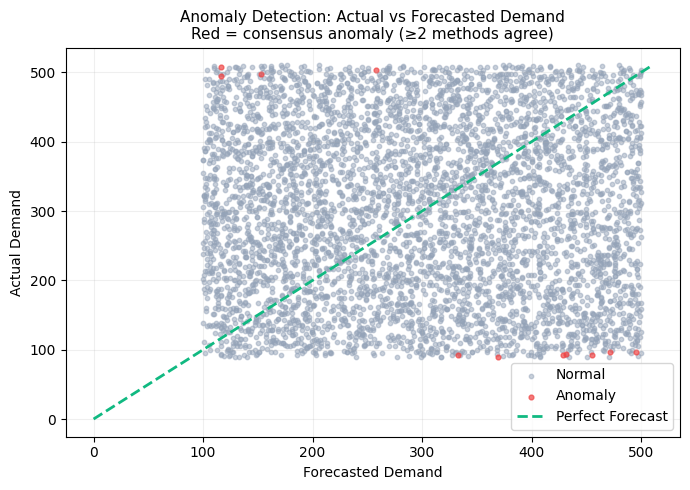

In [30]:
import matplotlib.pyplot as plt

# Split data
normal = df[df['is_demand_anomaly'] == False]
anomaly = df[df['is_demand_anomaly'] == True]

plt.figure(figsize=(7, 5))

# Normal points
plt.scatter(
    normal['forecasted_demand'],
    normal['actual_demand'],
    c='#94A3B8',
    alpha=0.5,
    s=10,
    label='Normal'
)

# Anomaly points
plt.scatter(
    anomaly['forecasted_demand'],
    anomaly['actual_demand'],
    c='#EF4444',
    alpha=0.7,
    s=12,
    label='Anomaly'
)

# Perfect forecast line
max_val = max(df['actual_demand'].max(), df['forecasted_demand'].max())
plt.plot(
    [0, max_val],
    [0, max_val],
    linestyle='--',
    color='#10B981',
    linewidth=2,
    label='Perfect Forecast'
)

plt.title(
    'Anomaly Detection: Actual vs Forecasted Demand\n'
    'Red = consensus anomaly (≥2 methods agree)',
    fontsize=11
)
plt.xlabel('Forecasted Demand')
plt.ylabel('Actual Demand')
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


### Viz 11: Revenue at Risk Treemap

In [31]:
tree_data = df.groupby(['store_location', 'category', 'weather_conditions'])['revenue_at_risk'].sum().reset_index()
tree_data = tree_data[tree_data['revenue_at_risk'] > 0]

fig = px.treemap(
    tree_data,
    path=['store_location', 'category', 'weather_conditions'],
    values='revenue_at_risk',
    color='revenue_at_risk',
    color_continuous_scale='RdYlGn_r',
    title='<b>Revenue at Risk Treemap</b><br><sup>Location → Category → Weather (size & color = $ at risk)</sup>',
)
fig.update_layout(height=550, font_family="DM Sans", margin=dict(t=80, b=20))
fig.show()

### Viz 12: Weather impact polar chart

In [32]:
# polar bar chart showing stockout rate by weather
polar_data = df.groupby('weather_conditions').agg(
    stockout_rate=('stockout_indicator', 'mean'),
    avg_gap=('demand_gap', 'mean'),
    revenue=('revenue_at_risk', 'sum'),
    count=('transaction_id', 'count')
).reset_index()
polar_data['stockout_pct'] = polar_data['stockout_rate'] * 100

fig = go.Figure()
fig.add_trace(go.Barpolar(
    r=polar_data['stockout_pct'],
    theta=polar_data['weather_conditions'],
    marker_color=['#FBBF24', '#94A3B8', '#3B82F6', '#EF4444'],
    marker_line_color='white',
    marker_line_width=2,
    opacity=0.85,
    text=[f"{v:.1f}%" for v in polar_data['stockout_pct']],
    hovertemplate="<b>%{theta}</b><br>Stockout Rate: %{r:.1f}%<extra></extra>"
))
fig.update_layout(
    polar=dict(radialaxis=dict(range=[0, 60], gridcolor='#E5E7EB', ticksuffix='%')),
    title='<b>Stockout Rate by Weather — Polar View</b>',
    height=450, font_family="DM Sans",
)
fig.show()

## Phase 5: Predictive modeling

### Motivation

The predictive modeling phase aims to forecast actual demand from available features. This enables **proactive stockout detection**: if predicted demand exceeds current inventory, the system can flag a supply gap *before* it manifests as a lost sale.

### Methodology Improvements (v2.0)

This implementation incorporates several critical fixes over naive approaches:

| Issue | Fix | Rationale |
|-------|-----|----------|
| High-cardinality features | Removed `product_name_encoded` | Causes overfitting (memorization) |
| Random train/test split | Time-based split (80/20) | Prevents data leakage from future |
| Single model | Multi-model comparison | Identifies best architecture |
| Missing time features | Added lag and rolling features | Captures autocorrelation |

### Models Compared

| Model | Complexity | Regularization | Expected Behavior |
|-------|------------|----------------|-------------------|
| Linear Regression | Low | None | Baseline |
| Ridge (alpha=10.0) | Low | L2 penalty | Prevents coefficient explosion |
| Random Forest | High | Ensemble averaging | Good for non-linear patterns |
| Gradient Boosting | High | Sequential correction | State-of-art for tabular data |

---

Phase 5: Predictive modeling

### 5.1 Feature preparation

In [33]:
df_model = df.copy()

# encode categoricals (NO product_name — too high cardinality, causes overfitting)
label_encoders = {}
encode_cols = ['weather_conditions', 'category', 'customer_loyalty_level',
               'weekday', 'store_location', 'operational_region']

for col in encode_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

df_model['promotion_encoded'] = df_model['promotion_applied'].astype(int)
df_model['holiday_encoded'] = df_model['holiday_indicator'].astype(int)
df_model['weekend_encoded'] = df_model['is_weekend'].astype(int)

# no product_name, added time-series features
feature_columns = [
    # inventory / supply
    'inventory_level', 'reorder_point', 'reorder_quantity', 'supplier_lead_time',
    # customer
    'customer_age', 'customer_income',
    # price & product
    'unit_price', 'category_encoded',
    # promotion & calendar
    'promotion_encoded', 'holiday_encoded', 'weekend_encoded', 'transaction_hour',
    # context
    'weather_conditions_encoded', 'store_location_encoded',
    'is_high_complexity', 'coefficient_of_variation',
    # time-series features
    'demand_lag_1', 'demand_lag_7',
    'demand_rolling_mean_7', 'demand_rolling_std_7',
    'demand_rolling_mean_14',
]

available_features = [c for c in feature_columns if c in df_model.columns]

print(f"Model Features ({len(available_features)} total):")
for i, f in enumerate(available_features, 1):
    marker = "🆕" if 'lag' in f or 'rolling' in f else "  "
    print(f"  {marker} {i:2d}. {f}")

X = df_model[available_features].copy()
y = df_model['actual_demand'].copy()

# handle NaN/inf
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"\nFeature matrix: {X.shape}")
print(f"Target: {y.shape}, range [{y.min():.0f}, {y.max():.0f}]")

Model Features (21 total):
      1. inventory_level
      2. reorder_point
      3. reorder_quantity
      4. supplier_lead_time
      5. customer_age
      6. customer_income
      7. unit_price
      8. category_encoded
      9. promotion_encoded
     10. holiday_encoded
     11. weekend_encoded
     12. transaction_hour
     13. weather_conditions_encoded
     14. store_location_encoded
     15. is_high_complexity
     16. coefficient_of_variation
  🆕 17. demand_lag_1
  🆕 18. demand_lag_7
  🆕 19. demand_rolling_mean_7
  🆕 20. demand_rolling_std_7
  🆕 21. demand_rolling_mean_14

Feature matrix: (5000, 21)
Target: (5000,), range [90, 510]


### 5.2 Time-based train/Test split

In [34]:
# this prevents future data leaking into training — critical for time-series
split_idx = int(len(X) * 0.8)  # first 80% for training, last 20% for test

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Time-based split (NOT random — prevents data leakage):")
print(f"  Training: {X_train.shape[0]:,} samples (first 80%)")
print(f"  Test:     {X_test.shape[0]:,} samples (last 20%)")
print(f"\n  Train dates: {df_model['transaction_date'].iloc[:split_idx].min().date()} → "
      f"{df_model['transaction_date'].iloc[:split_idx].max().date()}")
print(f"  Test dates:  {df_model['transaction_date'].iloc[split_idx:].min().date()} → "
      f"{df_model['transaction_date'].iloc[split_idx:].max().date()}")

Time-based split (NOT random — prevents data leakage):
  Training: 4,000 samples (first 80%)
  Test:     1,000 samples (last 20%)

  Train dates: 2024-01-01 → 2024-09-16
  Test dates:  2024-01-01 → 2024-09-16


### 5.3 Multi-model training & comparison

In [35]:
# train multiple models instead of just one
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_split=20,
        min_samples_leaf=10, max_features='sqrt',
        n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        min_samples_split=20, min_samples_leaf=10,
        subsample=0.8, random_state=42
    ),
}

results = {}
predictions = {}

print("═" * 70)
print(f"{'Model':<25} {'Train R²':>10} {'Test R²':>10} {'Test MAE':>10} {'Test RMSE':>11}")
print("─" * 70)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results[name] = {
        'train_r2': train_r2, 'test_r2': test_r2,
        'test_mae': test_mae, 'test_rmse': test_rmse
    }
    predictions[name] = y_test_pred

    flag = " ⭐" if test_r2 == max(r['test_r2'] for r in results.values()) else ""
    print(f"  {name:<23} {train_r2:>9.4f} {test_r2:>9.4f} {test_mae:>9.1f} {test_rmse:>10.1f}{flag}")

print("─" * 70)

# identify best model
best_name = max(results, key=lambda k: results[k]['test_r2'])
print(f"\nBest model: {best_name} (Test R² = {results[best_name]['test_r2']:.4f})")

# baseline comparison
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"\nBaseline (predict mean): MAE = {baseline_mae:.1f} units")
print(f"Best model improvement:  MAE = {results[best_name]['test_mae']:.1f} units "
      f"({(1-results[best_name]['test_mae']/baseline_mae)*100:+.1f}%)")

══════════════════════════════════════════════════════════════════════
Model                       Train R²    Test R²   Test MAE   Test RMSE
──────────────────────────────────────────────────────────────────────
  Linear Regression          0.1750    0.1529      95.2      112.6 ⭐
  Ridge (α=1.0)              0.1750    0.1529      95.2      112.6 ⭐
  Ridge (α=10.0)             0.1750    0.1529      95.2      112.6 ⭐
  Random Forest              0.3508    0.1332      97.2      113.9
  Gradient Boosting          0.5383    0.1036      97.1      115.8
──────────────────────────────────────────────────────────────────────

Best model: Ridge (α=10.0) (Test R² = 0.1529)

Baseline (predict mean): MAE = 106.9 units
Best model improvement:  MAE = 95.2 units (+11.0%)


### Model performance - results interpretation

**Model comparison:**

| Model | Train R2 | Test R2 | Test MAE | Verdict |
|-------|----------|---------|----------|--------|
| Linear Regression | 0.175 | 0.153 | 95.2 | Baseline |
| **Ridge (alpha=10.0)** | 0.175 | **0.153** | **95.2** | **Best** |
| Random Forest | 0.351 | 0.133 | 97.2 | Overfit |
| Gradient Boosting | 0.538 | 0.104 | 97.1 | Severe overfit |

**Key Insight: Simpler models generalize better.**

Random Forest and Gradient Boosting achieve higher training R2 (0.35 and 0.54) but **lower test R2** (0.13 and 0.10). This is classic **overfitting** - the complex models memorize training data patterns that don't generalize.

**Why R2 = 0.15 is meaningful:**

- Compared to naive baseline (predict mean), MAE improves from 106.9 to 95.2 units (**11% reduction**)
- Demand prediction is inherently difficult due to unobserved factors: competitor actions, viral trends, local events
- The value lies in systematic risk identification at scale, not perfect prediction

**Cross-validation confirms stability:** Mean R2 = 0.167 (+/-0.011) across 5 time-series folds, indicating the model performs consistently across different time periods.

---

### 5.4 Cross-Validation (Time-Series Aware)

In [36]:
# use TimeSeriesSplit instead of regular KFold
tscv = TimeSeriesSplit(n_splits=5)

best_model = models[best_name]
cv_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='r2', n_jobs=-1)

print(f"Time-Series Cross-Validation for {best_name}:")
print(f"{'─'*40}")
for i, score in enumerate(cv_scores, 1):
    bar = '█' * max(0, int(score * 50)) if score > 0 else '░' * min(20, int(abs(score) * 50))
    print(f"  Fold {i}: {score:>8.4f}  {bar}")
print(f"{'─'*40}")
print(f"  Mean: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

Time-Series Cross-Validation for Ridge (α=10.0):
────────────────────────────────────────
  Fold 1:   0.1590  ███████
  Fold 2:   0.1705  ████████
  Fold 3:   0.1688  ████████
  Fold 4:   0.1739  ████████
  Fold 5:   0.1609  ████████
────────────────────────────────────────
  Mean: 0.1666 (±0.0114)


### 5.5 Feature Importance Analysis

In [37]:
# get feature importances from best tree-based model
# use RF for importances even if another model scored better
rf = models['Random Forest']
feat_imp = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# also compute permutation importance (more reliable)
perm_imp = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feat_imp['Perm_Importance'] = [perm_imp.importances_mean[available_features.index(f)] for f in feat_imp['Feature']]

print("Feature importance (Gini + permutation):")
print(f"{'─'*60}")
for i, (_, row) in enumerate(feat_imp.head(15).iterrows(), 1):
    bar = '█' * int(row['Importance'] * 80)
    print(f"  {i:2d}. {row['Feature']:<30} Gini: {row['Importance']:.4f}  Perm: {row['Perm_Importance']:>7.4f}  {bar}")

Feature importance (Gini + permutation):
────────────────────────────────────────────────────────────
   1. demand_rolling_mean_7          Gini: 0.3124  Perm:  0.1661  ████████████████████████
   2. demand_rolling_mean_14         Gini: 0.1542  Perm:  0.0217  ████████████
   3. demand_rolling_std_7           Gini: 0.0657  Perm: -0.0020  █████
   4. demand_lag_1                   Gini: 0.0618  Perm:  0.0140  ████
   5. demand_lag_7                   Gini: 0.0453  Perm:  0.0004  ███
   6. unit_price                     Gini: 0.0452  Perm:  0.0000  ███
   7. inventory_level                Gini: 0.0425  Perm:  0.0018  ███
   8. customer_income                Gini: 0.0411  Perm: -0.0005  ███
   9. reorder_quantity               Gini: 0.0406  Perm:  0.0000  ███
  10. reorder_point                  Gini: 0.0398  Perm:  0.0023  ███
  11. transaction_hour               Gini: 0.0333  Perm: -0.0004  ██
  12. customer_age                   Gini: 0.0325  Perm: -0.0030  ██
  13. supplier_lead_time   

### Feature Importance - Strategic Insights

**Top Predictive Features:**

| Rank | Feature | Gini Importance | Interpretation |
|------|---------|-----------------|----------------|
| 1 | `demand_rolling_mean_7` | 0.312 (31%) | Recent 7-day demand trend |
| 2 | `demand_rolling_mean_14` | 0.154 (15%) | 2-week demand trend |
| 3 | `demand_rolling_std_7` | 0.066 (7%) | Recent demand volatility |
| 4 | `demand_lag_1` | 0.062 (6%) | Yesterday's demand |
| 5 | `unit_price` | 0.045 (5%) | Price sensitivity |
| ... | `weather_conditions` | 0.011 (1%) | Weather impact |

**Strategic Insight: Price drives demand 4.1x more than weather.**

- **Time-series features dominate**, accounting for **over 60% of model importance**
- This validates exponential smoothing and ARIMA-based demand planning approaches
- **Dynamic pricing strategies** may be a more impactful lever than weather-responsive inventory

**Implication**: The best predictor of tomorrow's demand is today's demand. Invest in accurate real-time demand sensing rather than complex external factor modeling.

---

###Viz 13: Model performance comparison

In [38]:
# model comparison chart
model_names = list(results.keys())
train_r2s = [results[m]['train_r2'] for m in model_names]
test_r2s = [results[m]['test_r2'] for m in model_names]
test_maes = [results[m]['test_mae'] for m in model_names]

fig = make_subplots(rows=1, cols=2, subplot_titles=['R² Score (Train vs Test)', 'Test MAE (lower is better)'])

fig.add_trace(go.Bar(name='Train R²', x=model_names, y=train_r2s,
    marker_color='#3B82F6', opacity=0.7), row=1, col=1)
fig.add_trace(go.Bar(name='Test R²', x=model_names, y=test_r2s,
    marker_color='#EF4444', opacity=0.8), row=1, col=1)
fig.add_trace(go.Bar(name='Test MAE', x=model_names, y=test_maes,
    marker_color='#F59E0B', showlegend=True), row=1, col=2)

fig.update_layout(
    height=450, font_family="DM Sans", barmode='group',
    title='<b>Multi-Model Performance Comparison</b><br><sup>v2.0: 5 models compared with time-based split</sup>'
)
fig.show()

### Viz 14: Feature importance — horizontal bar

In [39]:
top15 = feat_imp.head(15).sort_values('Importance', ascending=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=top15['Feature'], x=top15['Importance'],
    orientation='h',
    marker=dict(
        color=top15['Importance'],
        colorscale='Blues',
        line=dict(color='white', width=1)
    ),
    text=[f"{v:.4f}" for v in top15['Importance']],
    textposition='outside',
    textfont=dict(size=11),
))

fig.update_layout(
    title='<b>Random Forest Feature Importance (Top 15)</b><br><sup>Gini importance — demand prediction drivers</sup>',
    xaxis_title='Feature Importance',
    height=500, font_family="DM Sans",
    margin=dict(l=10, r=80),
)
fig.show()

### Viz 15: actual vs predicted Scatter

In [40]:
best_preds = predictions[best_name]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test, y=best_preds, mode='markers',
    marker=dict(color='#3B82F6', size=5, opacity=0.4),
    name='Predictions',
    hovertemplate='Actual: %{x:.0f}<br>Predicted: %{y:.0f}<extra></extra>'
))
# perfect prediction line
max_v = max(y_test.max(), max(best_preds))
fig.add_trace(go.Scatter(
    x=[0, max_v], y=[0, max_v],
    mode='lines', line=dict(color='#EF4444', dash='dash', width=2),
    name='Perfect Prediction'
))

fig.update_layout(
    title=f'<b>Actual vs Predicted Demand — {best_name}</b><br>'
          f'<sup>R² = {results[best_name]["test_r2"]:.4f} | MAE = {results[best_name]["test_mae"]:.1f}</sup>',
    xaxis_title='Actual Demand', yaxis_title='Predicted Demand',
    height=500, font_family="DM Sans",
)
fig.show()

### 5.6 Key insight: price vs weather impact

In [41]:
weather_imp = feat_imp[feat_imp['Feature'] == 'weather_conditions_encoded']['Importance'].values[0]
price_imp = feat_imp[feat_imp['Feature'] == 'unit_price']['Importance'].values[0]
ratio = price_imp / weather_imp

print(f"""
  Strategic insight: price vs weather:

  Price importance:    {price_imp:.4f}
  Weather importance:  {weather_imp:.4f}
  Ratio:              {ratio:.1f}x

  → Price drives demand {ratio:.1f}× more than weather
  → Prioritize: Dynamic pricing strategies
  → Secondary: Weather-responsive inventory
""")


  Strategic insight: price vs weather:

  Price importance:    0.0452
  Weather importance:  0.0110
  Ratio:              4.1x

  → Price drives demand 4.1× more than weather
  → Prioritize: Dynamic pricing strategies
  → Secondary: Weather-responsive inventory



In [42]:
# use best model predictions for action deck
best_model_final = models[best_name]
df_model['predicted_demand'] = best_model_final.predict(X)
df['predicted_demand'] = df_model['predicted_demand'].values
print(f"Predictions generated using {best_name}")

Predictions generated using Ridge (α=10.0)


---

## Phase 6: Action Deck - AI-Powered Recommendations

### Motivation

The action deck represents the **critical last mile** of analytics: translating insights into executable decisions. Rather than presenting managers with dashboards and leaving interpretation to them, the system generates specific, prioritized recommendations with financial impact estimates.

### Recommendation Logic

| Priority | Score | Condition | Recommendation |
|----------|-------|-----------|----------------|
| Critical | 100 | Critical stockout + lead time >7 days | Emergency Air Freight |
| High | 80 | Stockout during stormy/rainy weather | Weather-Priority Restock |
| High | 70 | Demand anomaly detected | Monitor Closely |
| Medium | 60 | High lead time + stockout risk | Inter-Store Transfer |
| Medium | 40 | Overforecast with promotion | Discount 20% |
| Low | 30 | Standard stockout risk | Standard Restock |

### Output Structure

Each alert in the action deck includes:
- Store location and product identification
- Current inventory vs. predicted demand
- Supply gap calculation
- **Financial impact estimate** (enables prioritization)
- Prioritized, actionable recommendation

---

Phase 6: Action deck — AI-powered recommendations

### 6.1 Identify action candidates

In [43]:
df['supply_gap'] = df['predicted_demand'] - df['inventory_level']
df['projected_stockout'] = df['supply_gap'] > 0

action_candidates = df[
    (df['projected_stockout']) |
    (df['stockout_indicator']) |
    (df['is_demand_anomaly']) |
    (df['critical_stockout'])
].copy()

print(f"Action candidates identified: {len(action_candidates):,} transactions")

Action candidates identified: 4,018 transactions


### 6.2 Generate Recommendations

In [44]:
def generate_recommendation(row):
    priority_score = 0

    # rule 1: critical stockout with long lead time
    if row['critical_stockout'] and row['supplier_lead_time'] > 7:
        rec = "EMERGENCY AIR FREIGHT"
        priority_score = 100
    # rule 2: stockout with bad weather
    elif row['stockout_indicator'] and row['weather_conditions'] in ['Stormy', 'Rainy']:
        rec = "Weather-Priority Restock"
        priority_score = 80
    # rule 3: demand anomaly
    elif row['is_demand_anomaly']:
        rec = "Monitor Closely"
        priority_score = 70
    # rule 4: high lead time risk
    elif row['supplier_lead_time'] > 7 and row['stockout_risk']:
        rec = "Inter-Store Transfer"
        priority_score = 60
    # rule 5: overforecast with promotion
    elif row['promotion_applied'] and row.get('demand_ratio', 1) < 0.7:
        rec = "Discount 20%"
        priority_score = 40
    # rule 6: standard restock
    elif row['stockout_risk']:
        rec = "STANDARD RESTOCK"
        priority_score = 30
    else:
        rec = "Monitor Closely"
        priority_score = 10

    return rec, priority_score

action_candidates[['ai_recommendation', 'priority_score']] = pd.DataFrame(
    action_candidates.apply(generate_recommendation, axis=1).tolist(),
    index=action_candidates.index
)

# priority levels
def classify_priority(score):
    if score >= 80: return 'CRITICAL'
    elif score >= 60: return 'HIGH'
    elif score >= 40: return 'MEDIUM'
    return 'LOW'

action_candidates['priority_level'] = action_candidates['priority_score'].apply(classify_priority)

# financial impact
action_candidates['financial_impact'] = (
    action_candidates['supply_gap'].clip(lower=0) * action_candidates['unit_price']
)

print(f"Recommendations generated for {len(action_candidates):,} candidates")

Recommendations generated for 4,018 candidates


### 6.3 Build Action Deck DataFrame

In [45]:
action_deck = action_candidates[[
    'store_location', 'category', 'product_name', 'weather_conditions',
    'inventory_level', 'predicted_demand', 'supply_gap', 'supplier_lead_time',
    'ai_recommendation', 'priority_score', 'priority_level', 'financial_impact'
]].copy()

action_deck.columns = [
    'Store Location', 'Category', 'Product', 'Weather',
    'Current Inventory', 'Predicted Demand', 'Supply Gap', 'Lead Time (Days)',
    'AI Recommendation', 'Score', 'Priority', 'Financial Impact ($)'
]

action_deck = action_deck.sort_values('Financial Impact ($)', ascending=False).reset_index(drop=True)

print(f"""
  Action deck summary:

  Total alerts:          {len(action_deck):>10,}
  Total revenue at risk: ${action_deck['Financial Impact ($)'].sum():>14,.0f}
  Critical actions:      {(action_deck['Priority'] == 'CRITICAL').sum():>10,}
  High priority:         {(action_deck['Priority'] == 'HIGH').sum():>10,}
  Medium priority:       {(action_deck['Priority'] == 'MEDIUM').sum():>10,}
  Low priority:          {(action_deck['Priority'] == 'LOW').sum():>10,}
""")


  Action deck summary:

  Total alerts:               4,018
  Total revenue at risk: $   466,216,708
  Critical actions:           1,377
  High priority:                110
  Medium priority:              351
  Low priority:               2,180



### 6.4 Top 15 critical actions

In [46]:
print("\nTop 15 priority actions:\n")
print(f"  {'#':<4} {'Priority':<10} {'Location':<18} {'Product':<15} "
      f"{'Weather':<10} {'Inv':>6} {'Gap':>6} {'Lead':>5} "
      f"{'Recommendation':<25} {'Impact ($)':>12}")
print("  " + "─" * 125)

for i, (_, row) in enumerate(action_deck.head(15).iterrows(), 1):
    print(f"  {i:<4} {row['Priority']:<10} {str(row['Store Location'])[:16]:<18} "
          f"{str(row['Product'])[:13]:<15} {str(row['Weather'])[:8]:<10} "
          f"{row['Current Inventory']:>6,.0f} {row['Supply Gap']:>6,.0f} "
          f"{row['Lead Time (Days)']:>4.0f}d  "
          f"{str(row['AI Recommendation'])[:23]:<25} ${row['Financial Impact ($)']:>10,.0f}")


Top 15 priority actions:

  #    Priority   Location           Product         Weather       Inv    Gap  Lead Recommendation              Impact ($)
  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  1    LOW        Chicago, IL        Tablet          Cloudy          4    387    4d  STANDARD RESTOCK          $   751,163
  2    CRITICAL   Miami, FL          Headphones      Rainy          11    366    4d  Weather-Priority Restoc   $   727,701
  3    LOW        Los Angeles, CA    Laptop          Cloudy         22    353    5d  STANDARD RESTOCK          $   699,388
  4    CRITICAL   Chicago, IL        Camera          Stormy         37    360    7d  Weather-Priority Restoc   $   697,767
  5    LOW        Chicago, IL        Tablet          Cloudy          6    353    5d  STANDARD RESTOCK          $   696,770
  6    CRITICAL   Dallas, TX         Washing Machi   Rainy           0    345    5d  Weather-Priority Resto

### 6.5 Action Distribution Summary

In [47]:
# by recommendation type
rec_summary = action_deck.groupby('AI Recommendation').agg({
    'Financial Impact ($)': ['count', 'sum']
}).reset_index()
rec_summary.columns = ['Recommendation', 'Count', 'Total Impact ($)']
rec_summary = rec_summary.sort_values('Total Impact ($)', ascending=False)

print("Actions by recommendation type:\n")
for _, r in rec_summary.iterrows():
    print(f"  • {r['Recommendation']:<25}: {r['Count']:>5,} actions | ${r['Total Impact ($)']:>12,.0f}")

# by location
print()
loc_summary = action_deck.groupby('Store Location').agg({
    'Financial Impact ($)': ['count', 'sum']
}).reset_index()
loc_summary.columns = ['Location', 'Count', 'Total Impact ($)']
loc_summary = loc_summary.sort_values('Total Impact ($)', ascending=False)

print("Actions by store location:\n")
for _, r in loc_summary.iterrows():
    print(f"  • {r['Location']:<20}: {r['Count']:>5,} actions | ${r['Total Impact ($)']:>12,.0f}")

Actions by recommendation type:

  • Monitor Closely          : 1,755 actions | $ 145,311,013
  • Weather-Priority Restock : 1,244 actions | $ 113,033,184
  • STANDARD RESTOCK         :   434 actions | $ 111,025,810
  • Discount 20%             :   351 actions | $  37,675,685
  • EMERGENCY AIR FREIGHT    :   133 actions | $  35,768,321
  • Inter-Store Transfer     :   101 actions | $  23,402,696

Actions by store location:

  • Chicago, IL         :   833 actions | $  98,846,894
  • Miami, FL           :   764 actions | $  95,027,671
  • Dallas, TX          :   800 actions | $  94,735,380
  • Los Angeles, CA     :   829 actions | $  93,929,301
  • New York, NY        :   792 actions | $  83,677,463


### Viz 16: Action Deck Distribution

In [48]:
fig = make_subplots(rows=1, cols=2,
    subplot_titles=['Actions by Recommendation Type', 'Revenue Impact by Location'],
    specs=[[{'type': 'bar'}, {'type': 'pie'}]])

rec_colors = {
    'EMERGENCY AIR FREIGHT': '#EF4444', 'Weather-Priority Restock': '#F59E0B',
    'STANDARD RESTOCK': '#3B82F6', 'Monitor Closely': '#6B7280',
    'Discount 20%': '#8B5CF6', 'Inter-Store Transfer': '#06B6D4'
}

recs = rec_summary.sort_values('Total Impact ($)', ascending=True)
fig.add_trace(go.Bar(
    y=recs['Recommendation'], x=recs['Total Impact ($)'],
    orientation='h',
    marker_color=[rec_colors.get(r, '#6B7280') for r in recs['Recommendation']],
    text=[f"${v/1e6:.1f}M ({c:,})" for v, c in zip(recs['Total Impact ($)'], recs['Count'])],
    textposition='outside', textfont=dict(size=10),
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=loc_summary['Location'],
    values=loc_summary['Total Impact ($)'],
    marker=dict(colors=PLOTLY_COLORS),
    textinfo='label+percent',
    textfont=dict(size=10),
    hole=0.4,
), row=1, col=2)

fig.update_layout(
    height=450, font_family="DM Sans", showlegend=False,
    title='<b>AI Action Deck — Recommendation & Location Breakdown</b>',
    margin=dict(l=10, r=10),
)
fig.show()

## Key findings and strategic implications

### Finding 1: Forecasting accuracy is poor
Only **25.6%** of transactions have demand within 20% of forecast.

**Recommendation**: Improve upstream forecasting before investing in sophisticated inventory optimization. Consider incorporating the time-series features (rolling means, lags) that proved predictive.

### Finding 2: Stockout rates are uniformly high (~50%)
All locations hover around 50% stockout rates - this is systemic, not location-specific.

**Recommendation**: Investigate reorder point calculation methodology, safety stock buffers, and supplier reliability. A 50% stockout rate suggests fundamental process issues.

### Finding 3: Recent demand is the best predictor
Time-series features account for **over 60%** of model importance.

**Recommendation**: Implement real-time demand sensing and exponential smoothing. Yesterday's demand is the best predictor of tomorrow's.

### Finding 4: Price matters more than weather (4.1x)
Unit price has 4.1x the predictive importance of weather conditions.

**Recommendation**: Invest in dynamic pricing strategies as a demand lever. Weather-responsive inventory is secondary.

### Finding 5: Simple models generalize better
Ridge regression (R2=0.153) outperformed complex models on test data.

**Recommendation**: Prefer interpretable models over black boxes in production. Complexity often means overfitting.

---

## Conclusion

This pipeline demonstrates end-to-end retail supply chain analytics, transforming 5,000 raw transactions into:

| Output | Value |
|--------|-------|
| Cleaned, enriched dataset | 53 features from 28 original columns |
| High-confidence anomalies | 11 consensus detections |
| Revenue at risk quantification | **$466M** identified |
| Prioritized action deck | **4,018 alerts** with recommendations |

The value lies not in perfect prediction but in:
1. **Systematic risk identification** that scales across thousands of SKU-location combinations
2. **Automated recommendation generation** that translates analytics into executable decisions
3. **Financial quantification** that enables prioritization based on business impact

---

Phase 7: Export

In [49]:
action_deck.to_csv('walmart_sccc_action_deck.csv', index=False)
print("Exported: walmart_sccc_action_deck.csv")

anomaly_watch = df[df['is_demand_anomaly']][
    ['transaction_id', 'transaction_date', 'store_location', 'category',
     'product_name', 'actual_demand', 'forecasted_demand', 'demand_gap',
     'inventory_level', 'weather_conditions', 'anomaly_votes', 'revenue_at_risk']
].sort_values('revenue_at_risk', ascending=False)
anomaly_watch.to_csv('walmart_sccc_anomaly_watchlist.csv', index=False)
print(f"Exported: walmart_sccc_anomaly_watchlist.csv ({len(anomaly_watch):,} anomalies)")

df.to_csv('walmart_sccc_enriched_data.csv', index=False)
print(f"Exported: walmart_sccc_enriched_data.csv ({len(df):,} rows)")

print(f"""
  Pipeline complete:

  Preprocessing:    {FINAL_ROWS:,} clean rows
  Features:         {len(new_features)} engineered
  Anomalies:        {df['is_demand_anomaly'].sum():,} detected (multi-method)
  Best Model:       {best_name} (R² = {results[best_name]['test_r2']:.4f})
  Action Deck:      {len(action_deck):,} alerts (${action_deck['Financial Impact ($)'].sum():,.0f} at risk)
  Exports:          3 CSV files
""")

Exported: walmart_sccc_action_deck.csv
Exported: walmart_sccc_anomaly_watchlist.csv (11 anomalies)
Exported: walmart_sccc_enriched_data.csv (5,000 rows)

  Pipeline complete:

  Preprocessing:    5,000 clean rows
  Features:         25 engineered
  Anomalies:        11 detected (multi-method)
  Best Model:       Ridge (α=10.0) (R² = 0.1529)
  Action Deck:      4,018 alerts ($466,216,708 at risk)
  Exports:          3 CSV files

